In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import json 
import networkx as nx
import operator

<h3> Compute cooking time </h3>

In [2]:
import json 

with open('/users/andrei/Downloads/recipes_with_nutritional_info_fixed_qty.json') as f : 
    recipes = json.load(f)
    
recipes_df = pd.read_json('/users/andrei/Downloads/recipes_with_nutritional_info_fixed_qty.json')

We will try to compute the cooking time for each recipe from the information contained in the instructions column.

In [3]:
# Keep the useful information.
recipes_df_time = recipes_df.copy()
recipes_df_time = recipes_df_time[['id','title','instructions']]

First of all, we compute the length of each instruction. This will be useful at the end of the computation.

In [4]:
recipes_df_time['length'] = recipes_df_time['instructions'].apply(lambda x : len(x))

We split the instructions for each recipe in a list of words.

In [5]:
# Get the sentences and join them in a single string.
recipes_df_time['instructions'] = recipes_df_time['instructions'].apply(lambda x : ' '.join([elt['text'] for elt in x]))

# Get a list with every normalized words.
recipes_df_time['instructions'] = recipes_df_time['instructions'].apply(lambda x : x.split(' '))
recipes_df_time['instructions'] = recipes_df_time['instructions'].apply(lambda x : [elt.strip('! \ / . ,; @ ~ ) ( +')\
                                                                                    .lower() for elt in x])

Now that we have a the list with the different words, we want to look for words that quantify the time.

In [6]:
# Define a list of time words.
time_words = ['second','seconds','sec','minute','minutes','min','hour','hours']

# Keep in a new column a list of time words identified in the instructions.
recipes_df_time['time'] = recipes_df_time['instructions'].apply(lambda x : [elt for elt in x if elt in time_words])

The next step is to find the values associated to those words. First, we will search for the indices of these values in the instructions : we look for the index of each time word and take the index before (as the value associated is probably located before the time word).

In [7]:
def return_indices_before(elt, li) :
    """ Returns a list of indices of the values associated with the time words"""
    return [i-1 for i,x in enumerate(li) if x == elt]

# Store the indices of the associated values in a new column.
recipes_df_time['indices'] = recipes_df_time['instructions'].apply(lambda x : [return_indices_before(elt,x) for elt in x \
                                                                               if elt in time_words])

We now need a little bit of further processing in order to get the list of indices associated with the values (the list previously obtained contains other lists and duplicates).

In [8]:
def explode_list(li) :  
    """ Returns a sorted exploded list containing unique elements"""
    li_ = []

    for elt in li : 
        if len(elt) < 2 : 
            li_.append(elt[0])
        else : 
            li_.extend(elt) 
            
    return sorted(list(set(li_)))

# Get the indices of the values in the right order.
recipes_df_time['indices'] = recipes_df_time['indices'].apply(lambda x : explode_list(x))

Finally, we store the values associated with the time words in a new column thanks to the indices.

In [9]:
recipes_df_time['times'] = recipes_df_time.apply(lambda row : [row.instructions[elt].strip() for elt in row.indices],\
                                                 axis=1)

The values we get are not all numbers. We need to do some mapping in order to replace exceptions with actual values that can be interpreted. For this, we analyzed the different values of the `times` column in order to handle the exceptions.

In [10]:
# Map the different time words to their values in minutes.
mapdict_time = {}
mapdict_time.update(dict.fromkeys(['sec','second','seconds'],str((1/60))))
mapdict_time.update(dict.fromkeys(['min','minute','minutes'],str(1)))
mapdict_time.update(dict.fromkeys(['hour','hours'],str(60)))

# Map different words to interpretable values.
mapdict_words = {}
mapdict_words.update(dict.fromkeys(['a','an','one','about1','another','additional','each','refrigerate1'\
                                   'another','other','final','0ne','extra'],str(1))) 
mapdict_words.update(dict.fromkeys(['few','of', 'several','more','couple','some'],str(5))) # Here, we arbitrarly map to 5.

# Map different expressions containing quantities to values.
mapdict_numbers = {'half' : str(0.5), '1/2' : str(0.5),'two' : str(2), 'three' : str(3), 'four' : str(4), 'five' : str(5),\
                   'about5' : str(5),'six' : str(6), 'seven' : str(7), 'eight' : str(8),'nine' : str(9), 'ten' : str(10),\
                   'twenty' : str(20), 'thirty' : str(30), 'forty' : str(40), 'fifty' : str(50), 'fifteen' : str(15),\
                  'triple' : str(3),'1/4' : str(0.25), 'twelve' : str(12), 'to2' : str(2),'rise45' : str(45),\
                  'dozen' : str(12),'refrigerate20' : str(20), 'refrigerate30' : str(30), 'refrigerate10' : str(10),\
                  'bake15' : str(15), 'additional5' : str(5),'boil.boil6' : str(6),'sixty' : str(60),'quarter' : str(0.25),\
                  '3/4' : str(0.75),'within3' : str(3)}

We now replace these values by their mapping. 

In [11]:
recipes_df_time['times'] = recipes_df_time['times'].apply(lambda x : [elt.replace(elt,mapdict_words[elt])\
                                                                      if elt in mapdict_words else elt for elt in x])

recipes_df_time['times'] = recipes_df_time['times'].apply(lambda x : [elt.replace(elt,mapdict_numbers[elt])\
                                                              if elt in mapdict_numbers else elt for elt in x])

We still have to deal with some other exceptions. Some values are expressed as 10-20 or 15~20. We will split those strings in two and take the average of the two values. Also, we observed some anormal values such as 1520 or 3540. We assumed these values have to be processed as 15-20 or 35-40. 

In [12]:
# Transform the large numbers into interval separated with -. 
recipes_df_time['times'] = recipes_df_time['times'].apply(lambda x : [elt.replace(elt,'-'.join([elt[:2],elt[2:]]))\
                                                              if (len(elt) == 4 and '.' not in elt) else elt for elt in x])

In [13]:
def deal_exceptions(li) :  
    """Deals with the values exceptions in a list"""
    
    li = [elt.replace(elt,mapdict_words[elt]) if elt in mapdict_words else elt for elt in li]
    li = [elt.replace(elt,mapdict_numbers[elt]) if elt in mapdict_numbers else elt for elt in li]
    
    return li


def mean_time(elt, sep) : 
    """Returns the mean between the two values separated by sep"""
    
    li = elt.split(sep)
    li = [word.strip(' ) ( ~ @ - = / \ | , . ; +') for word in li]
    li = deal_exceptions(li) # Deal with the exceptions. 
    
    try : 
        avg = (float(li[0]) + float(li[-1]))/2
        
    except : # We exclude other words that do not have an interpretation as a value.
        avg = 0 
    
    return str(round(avg,2))


# Get the mean values.
for sep in ['-','~','_','/','to'] : 
    recipes_df_time['times'] = recipes_df_time['times'].apply(lambda x : [elt.replace(elt,mean_time(elt,sep))\
                                                                          if sep in elt else elt for elt in x])

In [14]:
# Map the time words with their values in minutes.
recipes_df_time['time'] = recipes_df_time['time'].apply(lambda x : [elt.replace(elt,mapdict_time[elt]) for elt in x\
                                                            if elt in mapdict_time])

We now multiply the values with the time in minutes in order to get an approximate cooking time. We also add the length of the instructions (number of sentences) to each result, in order to have a cooking time for the recipes that do not contain any time word. In order to deal with the meaningless expressions in the times column, we assign them the value 0 when computing the cooking time.

In [15]:
def to_float(str) : 
    try : 
        return float(str)
    except : 
        return 0.0

In [16]:
# Convert the values to floats.
recipes_df_time['time'] = recipes_df_time['time'].apply(lambda x : [float(elt) for elt in x])
recipes_df_time['times'] =  recipes_df_time['times'].apply(lambda x : [to_float(elt) for elt in x])

recipes_df_time['cooking_time'] = recipes_df_time.apply(lambda row : int(sum(np.array(row.time)*np.array(row.times))\
                                                                         + row.length), axis =1)


In [17]:
recipes_df_time.drop(columns = ['indices','time','times','length'], inplace=True)

In [18]:
recipes_df_time.head(10)

,id,title,instructions,cooking_time
0,000095fc1d,Yogurt Parfaits,"[layer, all, ingredients, in, a, serving, dish]",1
1,00051d5b9d,"Salt Free, Low Cholesterol Sugar Cookies Recipe","[cream, sugar, and, butter, together, till, sm...",20
2,00059b093b,Honey Sriracha Chicken Wings,"[preheat, oven, to, 400, degrees, f, in, a, la...",66
3,0005fc89f7,Shrimp and Caper Salad,"[in, a, large, bowl, toss, the, shrimp, green,...",62
4,0006ca31f4,Natural Peanut Butter Chocolate Bon Bons,"[measure, out, the, cocoa, powder, into, a, mi...",126
5,00073a6b36,Easy Cheese Sauce,"[put, milk, onion, salt, and, pepper, sauce, i...",3
6,0007c8edef,Easy Chocolate Frosting Recipe,"[heat, chocolate, on, top, of, double, boiler,...",4
7,0007f5f800,Cornmeal Crackers with Pumpkin Seeds,"[in, a, large, skillet, stir, the, cornmeal, o...",91
8,0008c6e39a,Chocolate-Orange Angel Food Cake,"[move, oven, rack, to, lowest, position, heat,...",354
9,0009785a2e,"Rice With Lemon, Capers & Parsley","[add, rice, to, a, large, pan, of, boiling, wa...",27


We now build a graph based on the cooking time. 

In [19]:
recipes_graph = recipes_df_time[['title','cooking_time']]

In [20]:
def distance_matrix_np(pts):
    """Returns matrix of pairwise Euclidean distances"""
    n = pts.shape[0]
    distance = np.zeros((n,n))
    for i in range(n):
        distance[i,:] = np.square(pts - pts[i])
    return distance

First, most of the recipes have a cooking time of less than two hours, let's take a look at the distribution.

In [21]:
recipes_graph = recipes_graph[recipes_graph['cooking_time'] < 120]

Text(0, 0.5, 'Recipes counts')

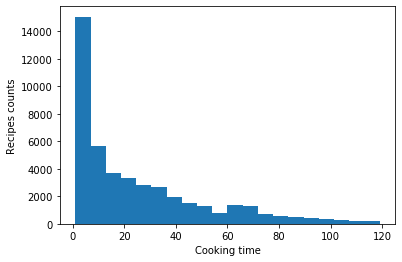

In [22]:
recipes_graph['cooking_time'].hist(bins=20, grid = False)
plt.xlabel('Cooking time')
plt.ylabel('Recipes counts')

In [23]:
recipes_graph_1 = recipes_graph[recipes_graph['cooking_time'] < 40]
recipes_graph_2 = recipes_graph[recipes_graph['cooking_time'] > 39]

In [24]:
#distance_1 = distance_matrix_np((recipes_graph_1['cooking_time']).to_numpy())
distance_2 = distance_matrix_np((recipes_graph_2['cooking_time']).to_numpy())

#mean_distance_1 = distance_1.mean()
mean_distance_2 = distance_2.mean()

In [25]:
#adjacency_1 = distance_1.copy()
#indices_1 = distance_1 < mean_distance_1
#adjacency_1[indices_1] = 0 
#adjacency_1[~indices_1] = 1 

adjacency_2 = distance_2.copy()
indices_2 = distance_2 < mean_distance_2
adjacency_2[indices_2] = 0 
adjacency_2[~indices_2] = 1 

In [26]:
#G_1 = nx.from_numpy_matrix(adjacency_1)
G_2 = nx.from_numpy_matrix(adjacency_2)

In [27]:
recipes_graph_2 = recipes_graph_2.reset_index()

In [28]:
degree_centrality = nx.degree_centrality(G_2)
recipes_centrality = sorted(degree_centrality.items(), key=operator.itemgetter(1), reverse=True)

# Generate id to name mapping for ingredients
recipes_id_to_val = recipes_graph_2.to_dict()['title']

for recipe in recipes_centrality[:10]:
    print(f"{recipes_id_to_val[recipe[0]]} has centrality {recipe[1]}")    

Apricot And Honey Jam Recipe has centrality 0.877121123464014
Pork (or Lamb) with Lentils has centrality 0.877121123464014
Make Ahead Brown Sugar and Spice Cake Mix has centrality 0.877121123464014
Blueberry Buckle (Vegan) has centrality 0.877121123464014
Bleu Broccoli Casserole has centrality 0.877121123464014
Salted Caramels has centrality 0.877121123464014
Sweet Potato Drop Biscuits has centrality 0.877121123464014
Better-than-Basic Wheat Bread has centrality 0.877121123464014
White Chocolate and Peppermint Cookie Brittle has centrality 0.877121123464014
Peach Jam has centrality 0.877121123464014


In [52]:
recipes_df['fat'] = recipes_df.nutr_values_per100g.apply(lambda x : round(x['fat'],2))

Clustering idea : we are interested in cooking time and fat values (considering we are interested in healthy recipes that we define by containing less fat). Since the recipes data frame is way too big, let's consider the first 1000 recipes (which are random, given that the initial recipes are not ordered). 

In [120]:
subdf = recipes_df_time.merge(recipes_df, on = 'id', copy=False)
subdf = subdf[['title_x','cooking_time','fat']]
subdf = subdf[subdf['cooking_time'] < 60] #Keep only under an hour.

In [121]:
X = np.zeros(shape=(1000,2))
X[:,0] = subdf.iloc[:1000].cooking_time.to_numpy()
X[:,1] = subdf.iloc[:1000].fat.to_numpy()

Text(0, 0.5, 'Fat')

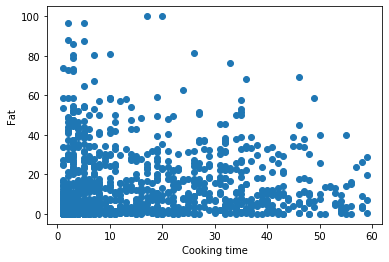

In [132]:
plt.scatter(X[:,0],X[:,1]) #Coordinates are cooking time and fat.
plt.xlabel('Cooking time')
plt.ylabel('Fat')

In [124]:
from sklearn.cluster import KMeans

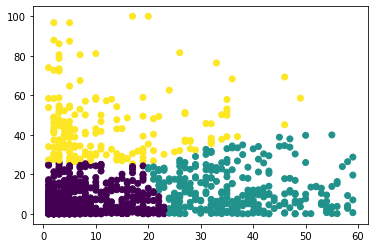

In [136]:
y_pred = KMeans(n_clusters=3).fit(X).labels_
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

In [148]:
indices = (y_pred == 0) #Low cooking time, low fat (healthy)

In [158]:
subdf.iloc[:1000][indices]

,title_x,cooking_time,fat
0,Yogurt Parfaits,1,2.14
5,Easy Cheese Sauce,3,21.69
6,Easy Chocolate Frosting Recipe,4,4.34
11,Creamed Broccoli And Cauliflower Soup Recipe,6,2.38
12,Fudgy Chocolate Cherry Float,20,2.21
...,...,...,...
1325,Blazing Mustard,3,1.87
1328,Strawgurt Smoothie,2,0.19
1331,Vinegar Soy Sauce,3,20.00
1334,Apricot Balls,15,20.09
